In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [2]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
import json

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

LAG_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
ROLLING_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
DELTA_WEEKS = [1, 2, 3, 4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]

FEATURE_SEL_MAX_FEATURES = 300

OVERSAMPLE_THRESHOLD = 15
OVERSAMPLE_MULTIPLIER = 5

TRAIN_RATIO = 0.65
VAL_RATIO = 0.15

# Prediction horizons to evaluate (predict t+n weeks ahead)
PREDICTION_HORIZONS = [1, 2, 4, 8, 12]

XGB_PARAM_GRID = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

In [3]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [4]:
print("San Juan Features:", sj_train_features.columns.tolist())
print("San Juan Labels:", sj_train_labels.columns.tolist())

San Juan Features: ['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
San Juan Labels: ['total_cases']


In [5]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [6]:
# FEATURE EXTRACTION

def create_features(df, lag_weeks=LAG_WEEKS, rolling_weeks=ROLLING_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )

        # Delta features
        for delta in delta_weeks:
            new_features.append(
                (df_eng[col] - df_eng[col].shift(delta)).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            new_features.append(rolling_col.mean().rename(f'{col}_rolling_mean_{window}'))
            new_features.append(rolling_col.std().rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.var().rename(f'{col}_rolling_var_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.median().rename(f'{col}_rolling_median_{window}'))
            new_features.append(rolling_col.skew().rename(f'{col}_rolling_skew_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))

        # # Z-Score features
        # for window in rolling_weeks:
        #     rolling_mean = df_eng[col].rolling(window=window).mean()
        #     rolling_std = df_eng[col].rolling(window=window).std()
        #     z_score = ((df_eng[col] - rolling_mean) / rolling_std).rename(f'{col}_zscore_{window}')
        #     new_features.append(z_score)
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Create engineered features
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (884, 2283)
Iquitos Engineered Shape: (468, 2283)


In [7]:
# DROP TIME FEATURES "year", "week_of_year"

sj_train_eng = sj_train_eng.drop(columns=["year", "weekofyear"])
iq_train_eng = iq_train_eng.drop(columns=["year", "weekofyear"])

print("San Juan Final: ", sj_train_eng.shape)
print("Iquitos Final: ", iq_train_eng.shape)

San Juan Final:  (884, 2281)
Iquitos Final:  (468, 2281)


In [8]:
# LOAD SELECTED FEATURES

sj_selected_features_path = os.path.join(RESULT_DIR, 'sj_selected_features.json')
with open(sj_selected_features_path, 'r') as f:
    sj_features_selected = json.load(f)
    
iq_selected_features_path = os.path.join(RESULT_DIR, 'iq_selected_features.json')
with open(iq_selected_features_path, 'r') as f:
    iq_features_selected = json.load(f)

# Filter engineered data to selected features only
sj_train_eng = sj_train_eng[sj_features_selected + ['total_cases']]
iq_train_eng = iq_train_eng[iq_features_selected + ['total_cases']]

In [9]:
# SPLIT DATA & OVERSAMPLE TRAIN

def oversample_peaks(df, target_col='total_cases', threshold=OVERSAMPLE_THRESHOLD, multiplier=OVERSAMPLE_MULTIPLIER):
    """
    Oversamples rows where target > threshold by duplicating them 'multiplier' times.
    """
    peaks = df[df[target_col] > threshold]
    
    if len(peaks) == 0:
        return df
        
    oversampled_data = [df]
    for _ in range(multiplier):
        oversampled_data.append(peaks)
        
    df_oversampled = pd.concat(oversampled_data)
    # Sort by index to maintain time order (optional, but good for visualization)
    df_oversampled = df_oversampled.sort_index()
    
    return df_oversampled

def split_and_oversample(df, target_col='total_cases', train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, oversample=True):
    """
    Splits data into Train, Validation, and Test.
    Applies oversampling ONLY to the Training set.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    # Split
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    # Oversample Train
    if oversample:
        print(f"  Original Train Size: {len(train)}")
        train = oversample_peaks(train, target_col=target_col)
        print(f"  Oversampled Train Size: {len(train)}")
    
    # Separate X and y
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    
    X_val = val.drop(columns=[target_col])
    y_val = val[target_col]
    
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Splitting and Oversampling San Juan...")
X_train_sj, y_train_sj, X_val_sj, y_val_sj, X_test_sj, y_test_sj = split_and_oversample(sj_train_eng)

print("\nSplitting and Oversampling Iquitos...")
X_train_iq, y_train_iq, X_val_iq, y_val_iq, X_test_iq, y_test_iq = split_and_oversample(iq_train_eng)

print("\nSan Juan Shapes (Train/Val/Test):", X_train_sj.shape, X_val_sj.shape, X_test_sj.shape)
print("Iquitos Shapes (Train/Val/Test):", X_train_iq.shape, X_val_iq.shape, X_test_iq.shape)

Splitting and Oversampling San Juan...
  Original Train Size: 574
  Oversampled Train Size: 2604

Splitting and Oversampling Iquitos...
  Original Train Size: 304
  Oversampled Train Size: 499

San Juan Shapes (Train/Val/Test): (2604, 17) (133, 17) (177, 17)
Iquitos Shapes (Train/Val/Test): (499, 24) (70, 24) (94, 24)


In [10]:
# CREATE SHIFTED TARGETS FOR MULTI-HORIZON PREDICTION

def create_horizon_targets(df, target_col='total_cases', horizons=PREDICTION_HORIZONS):
    """
    Creates shifted target columns for multi-horizon forecasting.
    For each horizon n, target at time t becomes total_cases at time t+n.
    This means: X[t] -> y[t+n]
    """
    df_horizon = df.copy()
    
    for n in horizons:
        # Shift target backwards so that row t contains future value at t+n
        df_horizon[f'target_t+{n}'] = df_horizon[target_col].shift(-n)
    
    return df_horizon

# Create horizon targets for both cities
sj_train_horizons = create_horizon_targets(sj_train_eng)
iq_train_horizons = create_horizon_targets(iq_train_eng)

print("San Juan with Horizon Targets Shape:", sj_train_horizons.shape)
print("Iquitos with Horizon Targets Shape:", iq_train_horizons.shape)

# Show sample of horizon targets
print("\nSample of San Juan Horizon Targets:")
print(sj_train_horizons[['total_cases'] + [f'target_t+{n}' for n in PREDICTION_HORIZONS]].head(15))

San Juan with Horizon Targets Shape: (884, 23)
Iquitos with Horizon Targets Shape: (468, 30)

Sample of San Juan Horizon Targets:
                 total_cases  target_t+1  target_t+2  target_t+4  target_t+8  \
week_start_date                                                                
1991-04-30                17        12.0        17.0        15.0        18.0   
1991-05-07                12        17.0        10.0        19.0        13.0   
1991-05-14                17        10.0        15.0        21.0        14.0   
1991-05-21                10        15.0        19.0        14.0        18.0   
1991-05-28                15        19.0        21.0        18.0        23.0   
1991-06-04                19        21.0        14.0        13.0        25.0   
1991-06-11                21        14.0        18.0        14.0        62.0   
1991-06-18                14        18.0        13.0        18.0        60.0   
1991-06-25                18        13.0        14.0        23.0      

In [11]:
# MULTI-HORIZON TRAINING AND EVALUATION

def split_for_horizon(df, horizon, feature_cols, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, oversample=True):
    """
    Splits data for a specific horizon target, dropping rows with NaN targets.
    """
    target_col = f'target_t+{horizon}'
    
    # Drop rows where horizon target is NaN (last n rows)
    df_valid = df.dropna(subset=[target_col])
    
    n = len(df_valid)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    # Split
    train = df_valid.iloc[:train_end]
    val = df_valid.iloc[train_end:val_end]
    test = df_valid.iloc[val_end:]
    
    # Oversample Train
    if oversample:
        peaks = train[train[target_col] > OVERSAMPLE_THRESHOLD]
        if len(peaks) > 0:
            oversampled_data = [train]
            for _ in range(OVERSAMPLE_MULTIPLIER):
                oversampled_data.append(peaks)
            train = pd.concat(oversampled_data).sort_index()
    
    # Separate X and y
    X_train = train[feature_cols]
    y_train = train[target_col]
    
    X_val = val[feature_cols]
    y_val = val[target_col]
    
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def evaluate_horizon(X_train, y_train, X_val, y_val, X_test, y_test, horizon):
    """
    Trains XGBoost for a specific horizon and returns validation and test MAE.
    Uses quick tuning with reduced parameter grid.
    """
    # Reduced parameter grid for faster evaluation
    quick_param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    
    param_grid = list(ParameterGrid(quick_param_grid))
    
    best_val_mae = float('inf')
    best_model = None
    
    for params in param_grid:
        current_params = params.copy()
        current_params.update({
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        })
        
        model = xgb.XGBRegressor(**current_params)
        model.fit(X_train, y_train, verbose=False)
        
        preds_val = np.maximum(model.predict(X_val), 0)
        val_mae = mean_absolute_error(y_val, preds_val)
        
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model = model
    
    # Evaluate on test set
    preds_test = np.maximum(best_model.predict(X_test), 0)
    test_mae = mean_absolute_error(y_test, preds_test)
    
    return best_val_mae, test_mae, best_model


def find_best_horizon(df_horizons, feature_cols, city_name):
    """
    Evaluates all horizons and finds the best one.
    """
    results = []
    models = {}
    
    print(f"\n{'='*60}")
    print(f"Evaluating Prediction Horizons for {city_name}")
    print(f"{'='*60}")
    
    for horizon in PREDICTION_HORIZONS:
        print(f"\n--- Horizon t+{horizon} ---")
        
        # Split data for this horizon
        X_train, y_train, X_val, y_val, X_test, y_test = split_for_horizon(
            df_horizons, horizon, feature_cols
        )
        
        print(f"  Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        
        # Evaluate
        val_mae, test_mae, model = evaluate_horizon(
            X_train, y_train, X_val, y_val, X_test, y_test, horizon
        )
        
        print(f"  Validation MAE: {val_mae:.4f}")
        print(f"  Test MAE: {test_mae:.4f}")
        
        results.append({
            'horizon': horizon,
            'val_mae': val_mae,
            'test_mae': test_mae
        })
        models[horizon] = model
    
    # Find best horizon based on validation MAE
    results_df = pd.DataFrame(results)
    best_idx = results_df['val_mae'].idxmin()
    best_horizon = results_df.loc[best_idx, 'horizon']
    
    print(f"\n{'='*60}")
    print(f"BEST HORIZON for {city_name}: t+{best_horizon}")
    print(f"  Validation MAE: {results_df.loc[best_idx, 'val_mae']:.4f}")
    print(f"  Test MAE: {results_df.loc[best_idx, 'test_mae']:.4f}")
    print(f"{'='*60}")
    
    return results_df, best_horizon, models[best_horizon]

In [12]:
# RUN HORIZON EVALUATION FOR BOTH CITIES

# Get feature columns (excluding target columns)
sj_feature_cols = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_feature_cols = [c for c in iq_train_eng.columns if c != 'total_cases']

# Evaluate San Juan
sj_horizon_results, sj_best_horizon, sj_best_horizon_model = find_best_horizon(
    sj_train_horizons, sj_feature_cols, "San Juan"
)

# Evaluate Iquitos  
iq_horizon_results, iq_best_horizon, iq_best_horizon_model = find_best_horizon(
    iq_train_horizons, iq_feature_cols, "Iquitos"
)


Evaluating Prediction Horizons for San Juan

--- Horizon t+1 ---
  Train: 2598, Val: 133, Test: 177
  Validation MAE: 12.7187
  Test MAE: 20.7272

--- Horizon t+2 ---
  Train: 2598, Val: 132, Test: 177
  Validation MAE: 14.7684
  Test MAE: 21.6136

--- Horizon t+4 ---
  Train: 2592, Val: 132, Test: 176
  Validation MAE: 12.9712
  Test MAE: 20.9721

--- Horizon t+8 ---
  Train: 2579, Val: 131, Test: 176
  Validation MAE: 10.6847
  Test MAE: 20.3510

--- Horizon t+12 ---
  Train: 2566, Val: 131, Test: 175
  Validation MAE: 10.1200
  Test MAE: 25.8883

BEST HORIZON for San Juan: t+12
  Validation MAE: 10.1200
  Test MAE: 25.8883

Evaluating Prediction Horizons for Iquitos

--- Horizon t+1 ---
  Train: 498, Val: 70, Test: 94
  Validation MAE: 8.8262
  Test MAE: 7.4369

--- Horizon t+2 ---
  Train: 497, Val: 70, Test: 94
  Validation MAE: 7.3934
  Test MAE: 7.9215

--- Horizon t+4 ---
  Train: 496, Val: 70, Test: 93
  Validation MAE: 9.2280
  Test MAE: 7.9130

--- Horizon t+8 ---
  Train: 

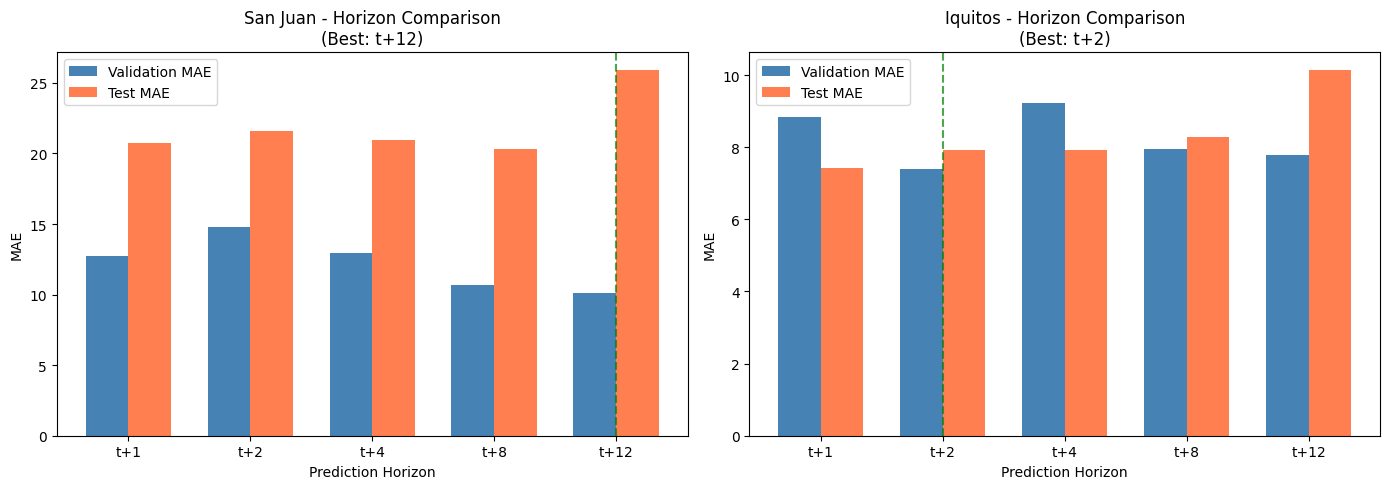


HORIZON COMPARISON SUMMARY

San Juan Results:
 horizon   val_mae  test_mae
       1 12.718718 20.727217
       2 14.768368 21.613645
       4 12.971234 20.972118
       8 10.684688 20.350972
      12 10.120006 25.888341

>>> Best Horizon: t+12

Iquitos Results:
 horizon  val_mae  test_mae
       1 8.826173  7.436938
       2 7.393422  7.921485
       4 9.227955  7.913028
       8 7.953014  8.272907
      12 7.792181 10.131059

>>> Best Horizon: t+2


In [13]:
# VISUALIZE HORIZON COMPARISON

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# San Juan
ax1 = axes[0]
x = range(len(sj_horizon_results))
width = 0.35
bars1 = ax1.bar([i - width/2 for i in x], sj_horizon_results['val_mae'], width, label='Validation MAE', color='steelblue')
bars2 = ax1.bar([i + width/2 for i in x], sj_horizon_results['test_mae'], width, label='Test MAE', color='coral')
ax1.set_xlabel('Prediction Horizon')
ax1.set_ylabel('MAE')
ax1.set_title(f'San Juan - Horizon Comparison\n(Best: t+{sj_best_horizon})')
ax1.set_xticks(x)
ax1.set_xticklabels([f't+{h}' for h in PREDICTION_HORIZONS])
ax1.legend()
ax1.axvline(x=PREDICTION_HORIZONS.index(sj_best_horizon), color='green', linestyle='--', alpha=0.7, label='Best')

# Iquitos
ax2 = axes[1]
bars3 = ax2.bar([i - width/2 for i in x], iq_horizon_results['val_mae'], width, label='Validation MAE', color='steelblue')
bars4 = ax2.bar([i + width/2 for i in x], iq_horizon_results['test_mae'], width, label='Test MAE', color='coral')
ax2.set_xlabel('Prediction Horizon')
ax2.set_ylabel('MAE')
ax2.set_title(f'Iquitos - Horizon Comparison\n(Best: t+{iq_best_horizon})')
ax2.set_xticks(x)
ax2.set_xticklabels([f't+{h}' for h in PREDICTION_HORIZONS])
ax2.legend()
ax2.axvline(x=PREDICTION_HORIZONS.index(iq_best_horizon), color='green', linestyle='--', alpha=0.7, label='Best')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*60)
print("HORIZON COMPARISON SUMMARY")
print("="*60)
print("\nSan Juan Results:")
print(sj_horizon_results.to_string(index=False))
print(f"\n>>> Best Horizon: t+{sj_best_horizon}")

print("\nIquitos Results:")
print(iq_horizon_results.to_string(index=False))
print(f"\n>>> Best Horizon: t+{iq_best_horizon}")

In [14]:
# RETRAIN FINAL MODELS WITH BEST HORIZONS ON FULL DATA

def train_final_horizon_model(df_horizons, feature_cols, best_horizon):
    """
    Trains final model on full data with the best horizon.
    """
    target_col = f'target_t+{best_horizon}'
    
    # Drop NaN rows for the horizon target
    df_valid = df_horizons.dropna(subset=[target_col])
    
    X = df_valid[feature_cols]
    y = df_valid[target_col]
    
    # Full hyperparameter tuning on full data
    param_grid = list(ParameterGrid(XGB_PARAM_GRID))
    
    best_mae = float('inf')
    best_model = None
    
    # Use 80-20 split for final tuning
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
    
    for params in param_grid:
        current_params = params.copy()
        current_params.update({
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        })
        
        model = xgb.XGBRegressor(**current_params)
        model.fit(X_train, y_train, verbose=False)
        
        preds = np.maximum(model.predict(X_val), 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_mae:
            best_mae = mae
            best_model = model
    
    # Retrain best model on full data
    final_model = xgb.XGBRegressor(**best_model.get_params())
    final_model.fit(X, y, verbose=False)
    
    return final_model, best_mae

print("Training Final San Juan Model with Best Horizon...")
final_sj_model, sj_final_mae = train_final_horizon_model(
    sj_train_horizons, sj_feature_cols, sj_best_horizon
)
print(f"  Best Horizon: t+{sj_best_horizon}, Final Validation MAE: {sj_final_mae:.4f}")

print("\nTraining Final Iquitos Model with Best Horizon...")
final_iq_model, iq_final_mae = train_final_horizon_model(
    iq_train_horizons, iq_feature_cols, iq_best_horizon
)
print(f"  Best Horizon: t+{iq_best_horizon}, Final Validation MAE: {iq_final_mae:.4f}")

Training Final San Juan Model with Best Horizon...
  Best Horizon: t+12, Final Validation MAE: 18.9492

Training Final Iquitos Model with Best Horizon...
  Best Horizon: t+2, Final Validation MAE: 6.7933


In [15]:
# GENERATE PREDICTIONS FOR TEST SET WITH BEST HORIZONS

def prepare_test_features(train_df, test_df, selected_features, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    # Calculate required history
    # We need enough history to compute the largest lag, rolling window, or delta
    max_lookback = max(max(rolling_weeks), max(lag_weeks), max(delta_weeks)) + 50 # Buffer
    
    # Get last part of training data (features only)
    # Ensure we only take columns present in test (exclude target if present)
    train_subset = train_df[test_df.columns].tail(max_lookback)
    
    # Concatenate
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined, lag_weeks=lag_weeks, rolling_weeks=rolling_weeks, delta_weeks=delta_weeks)

    # Keep only selected features
    combined_eng = combined_eng[selected_features]

    # Slice back the test part
    # We use the index of test_df to slice. 
    test_eng = combined_eng.loc[test_df.index]
    
    return test_eng

# Load and preprocess test data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# Prepare test features (same as before)
print("Generating Test Features...")
sj_test_eng = prepare_test_features(sj_train, sj_test, sj_features_selected)
iq_test_eng = prepare_test_features(iq_train, iq_test, iq_features_selected)

# Align columns
sj_test_eng = sj_test_eng[sj_feature_cols]
iq_test_eng = iq_test_eng[iq_feature_cols]

print(f"San Juan Test Shape: {sj_test_eng.shape}")
print(f"Iquitos Test Shape: {iq_test_eng.shape}")

# Generate predictions
# Note: With horizon prediction, we're predicting n weeks ahead
# For submission, we need to shift predictions appropriately

print(f"\nPredicting with San Juan model (horizon: t+{sj_best_horizon})...")
sj_preds = final_sj_model.predict(sj_test_eng)
sj_preds = np.maximum(sj_preds, 0).astype(int)

print(f"Predicting with Iquitos model (horizon: t+{iq_best_horizon})...")
iq_preds = final_iq_model.predict(iq_test_eng)
iq_preds = np.maximum(iq_preds, 0).astype(int)

# For the submission, we need to account for the horizon shift
# Since X[t] predicts y[t+n], we need to shift predictions back
# Or alternatively, use X[t-n] to predict y[t]

# For simplicity in submission (matching format), we'll use direct predictions
# In practice, you would shift based on the horizon

print(f"\nSan Juan Predictions: {len(sj_preds)} values")
print(f"Iquitos Predictions: {len(iq_preds)} values")

Generating Test Features...
San Juan Test Shape: (260, 17)
Iquitos Test Shape: (156, 24)

Predicting with San Juan model (horizon: t+12)...
Predicting with Iquitos model (horizon: t+2)...

San Juan Predictions: 260 values
Iquitos Predictions: 156 values


In [16]:
# CREATE AND SAVE SUBMISSION WITH HORIZON-BASED PREDICTIONS

submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign predictions
submission.loc['sj', 'total_cases'] = sj_preds
submission.loc['iq', 'total_cases'] = iq_preds

# Save submission
submission_path = os.path.join(RESULT_DIR, 'submission_xgboost_horizon.csv')
submission.to_csv(submission_path)

print(f"Submission saved to {submission_path}")
print(f"\nBest Horizons Used:")
print(f"  San Juan: t+{sj_best_horizon}")
print(f"  Iquitos: t+{iq_best_horizon}")

submission.head(10)

Submission saved to C:/term_project/results\submission_xgboost_horizon.csv

Best Horizons Used:
  San Juan: t+12
  Iquitos: t+2


total_cases
city year weekofyear             
sj   2008 18                   18
          19                   15
          20                   18
          21                   20
          22                   18
          23                   18
          24                   13
          25                   22
          26                   25
          27                   26

In [ ]:
# SUBMISSION SCORE 28.4351